Wikipedia QA Transformer Model

In [17]:
!pip install wikipedia-api beautifulsoup4 requests tiktoken torch transformers datasets accelerate

Scrap Wikipedia Articles

In [18]:
import wikipediaapi
import requests
import json

WIKI_LINKS = [
    "Artificial intelligence",
    "Machine learning",
    "Deep learning",
    "Natural language processing",
    "Transformer (machine learning model)",
    "Python (programming language)",
    "Neural network (machine learning)",
]

wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='MyQABot/1.0 (abrarshahriardotnet@gmail.com)'
)

def fetch_wikipedia_articles(titles):
    articles = []
    for title in titles:
        page = wiki.page(title)
        if page.exists():
            articles.append({
                'title': page.title,
                'text': page.text,
                'url': page.fullurl
            })
            print(f"Fetched: {page.title} ({len(page.text)} chars)")
        else:
            print(f"Not found: {title}")
    return articles

raw_articles = fetch_wikipedia_articles(WIKI_LINKS)
print(f"\nTotal articles fetched: {len(raw_articles)}")

Fetched: Artificial intelligence (85860 chars)
Fetched: Machine learning (59059 chars)
Fetched: Deep learning (56211 chars)
Fetched: Natural language processing (32227 chars)
Fetched: Transformer (deep learning) (112211 chars)
Fetched: Python (programming language) (39085 chars)
Fetched: Neural network (machine learning) (59205 chars)

Total articles fetched: 7


Text Preprocessing (NLP Cleaning)

In [19]:
import re

def preprocess_text(text):
    # Remove section headers (== Header ==)
    text = re.sub(r'==+.*?==+', '', text)
    # Remove citations [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r' +', ' ', text)
    # Remove very short lines (table artifacts)
    lines = [line.strip() for line in text.split('\n') if len(line.strip()) > 40]
    return ' '.join(lines)

def split_into_passages(text, max_words=150, overlap=30):
    """Split text into overlapping passages for QA context windows."""
    words = text.split()
    passages = []
    start = 0
    while start < len(words):
        end = min(start + max_words, len(words))
        passage = ' '.join(words[start:end])
        passages.append(passage)
        if end == len(words):
            break
        start += max_words - overlap
    return passages

# Process all articles
all_passages = []
for article in raw_articles:
    clean = preprocess_text(article['text'])
    passages = split_into_passages(clean)
    for p in passages:
        all_passages.append({
            'title': article['title'],
            'context': p
        })

print(f"Total passages created: {len(all_passages)}")
print("\nSample passage:")
print(all_passages[0]['context'][:300])

Total passages created: 456

Sample passage:
Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and so


GPT Tokenization with tiktoken

In [20]:
import tiktoken

# GPT-4 tokenizer (cl100k_base) — same as used by GPT-3.5/4
# For GPT-2 style: use 'gpt2'
tokenizer_enc = tiktoken.get_encoding("cl100k_base")

# Test tokenization
sample = all_passages[0]['context']
tokens = tokenizer_enc.encode(sample)
decoded = tokenizer_enc.decode(tokens)

print(f"Original text length: {len(sample)} chars")
print(f"Token count: {len(tokens)}")
print(f"First 20 tokens: {tokens[:20]}")
print(f"Decoded (should match original): {decoded[:200]}")

# Tokenize all passages and check distribution
token_counts = [len(tokenizer_enc.encode(p['context'])) for p in all_passages]
print(f"\nToken stats — Min: {min(token_counts)}, Max: {max(token_counts)}, Avg: {sum(token_counts)//len(token_counts)}")

Original text length: 1053 chars
Token count: 196
First 20 tokens: [9470, 16895, 11478, 320, 15836, 8, 374, 279, 23099, 315, 55580, 6067, 311, 2804, 9256, 11383, 5938, 449, 3823, 11478]
Decoded (should match original): Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and dec

Token stats — Min: 97, Max: 489, Avg: 198


Generate Synthetic QA Pairs from Passages
We use a pre-trained model to auto-generate Q&A pairs for fine-tuning

In [21]:
# Option A: Use rule-based approach (no extra API needed)
import re

def extract_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return [s.strip() for s in sentences if len(s.split()) > 8]

def make_qa_pairs_simple(passages, max_pairs=500):
    """Simple heuristic: first sentence of passage = answer, wrap as question."""
    qa_pairs = []
    for p in passages:
        sentences = extract_sentences(p['context'])
        if len(sentences) < 2:
            continue
        # Use passage as context, first meaningful sentence as answer
        answer = sentences[0]
        # Create a generic question using the title
        question = f"What is {p['title']}?"
        qa_pairs.append({
            'context': p['context'],
            'question': question,
            'answer': answer
        })
        if len(qa_pairs) >= max_pairs:
            break
    return qa_pairs

qa_data = make_qa_pairs_simple(all_passages)
print(f"Generated {len(qa_data)} QA pairs")
print("\nSample QA pair:")
print(f"Q: {qa_data[0]['question']}")
print(f"A: {qa_data[0]['answer']}")
print(f"Context (first 200): {qa_data[0]['context'][:200]}")

Generated 450 QA pairs

Sample QA pair:
Q: What is Artificial intelligence?
A: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making.
Context (first 200): Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and dec


Word Embeddings / Vectorization
We use HuggingFace tokenizer for model-compatible token IDs + embeddings

In [22]:
from transformers import AutoTokenizer
import torch

# Use GPT-2 tokenizer (BPE — same family as GPT tokenizers)
MODEL_NAME = "distilbert-base-uncased"  # Good for QA, fast to fine-tune
# Alternatives: 'bert-base-uncased', 'gpt2', 'roberta-base'

hf_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_qa_batch(qa_pairs, tokenizer, max_length=512):
    questions = [x['question'] for x in qa_pairs]
    contexts = [x['context'] for x in qa_pairs]

    encodings = tokenizer(
        questions,
        contexts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encodings

# Test on first 5 pairs
sample_encodings = tokenize_qa_batch(qa_data[:5], hf_tokenizer)
print("Tokenized batch shape:", sample_encodings['input_ids'].shape)
print("Keys:", list(sample_encodings.keys()))
print("\nSample input_ids (first 20 tokens of first example):")
print(sample_encodings['input_ids'][0][:20])

Tokenized batch shape: torch.Size([5, 222])
Keys: ['input_ids', 'token_type_ids', 'attention_mask']

Sample input_ids (first 20 tokens of first example):
tensor([  101,  2054,  2003,  7976,  4454,  1029,   102,  7976,  4454,  1006,
         9932,  1007,  2003,  1996, 10673,  1997, 15078,  3001,  2000,  4685])


Prepare Dataset for Training

In [23]:
from torch.utils.data import Dataset, DataLoader
import torch

class WikiQADataset(Dataset):
    def __init__(self, qa_pairs, tokenizer, max_length=512):
        self.encodings = tokenize_qa_batch(qa_pairs, tokenizer, max_length)

        # For extractive QA: find answer start/end token positions
        self.start_positions = []
        self.end_positions = []

        for i, pair in enumerate(qa_pairs):
            answer_text = pair['answer']
            context = pair['context']

            # Find char position of answer in context
            start_char = context.find(answer_text)
            if start_char == -1:
                start_char = 0
            end_char = start_char + len(answer_text)

            # Convert to token positions
            encoding = self.encodings
            try:
                start_token = encoding.char_to_token(i, start_char, sequence_index=1)
                end_token = encoding.char_to_token(i, end_char - 1, sequence_index=1)
                if start_token is None: start_token = 0
                if end_token is None: end_token = 0
            except:
                start_token, end_token = 0, 0

            self.start_positions.append(start_token)
            self.end_positions.append(end_token)

    def __len__(self):
        return len(self.start_positions)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['start_positions'] = torch.tensor(self.start_positions[idx])
        item['end_positions'] = torch.tensor(self.end_positions[idx])
        return item

# Split into train/val
split = int(0.9 * len(qa_data))
train_data = qa_data[:split]
val_data = qa_data[split:]

print("Building datasets...")
train_dataset = WikiQADataset(train_data, hf_tokenizer)
val_dataset = WikiQADataset(val_data, hf_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Building datasets...
Train size: 405, Val size: 45


Load Transformer Model for QA Fine-tuning

In [24]:
from transformers import AutoModelForQuestionAnswering, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained transformer with QA head
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForQuestionAnswering LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
qa_outputs.bias         | MISSING    | 
qa_outputs.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Total parameters: 66,364,418
Trainable parameters: 66,364,418


Training Loop

In [25]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Hyperparameters
EPOCHS = 3
LEARNING_RATE = 3e-5
WARMUP_STEPS = 100

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            start_positions=batch['start_positions'],
            end_positions=batch['end_positions']
        )

        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item():.4f}")

    return total_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                start_positions=batch['start_positions'],
                end_positions=batch['end_positions']
            )
            total_loss += outputs.loss.item()
    return total_loss / len(loader)

# ── TRAINING ──
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print('='*50)

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss = eval_epoch(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained('./best_qa_model')
        hf_tokenizer.save_pretrained('./best_qa_model')
        print(f"New best model saved!")

print("\nTraining complete!")


Epoch 1/3
  Batch 0/51 | Loss: 6.3561
  Batch 10/51 | Loss: 6.3682
  Batch 20/51 | Loss: 5.8787
  Batch 30/51 | Loss: 5.2746
  Batch 40/51 | Loss: 4.1661
  Batch 50/51 | Loss: 2.8234

Epoch 1 Summary:
  Train Loss: 5.2408
  Val Loss:   2.6092


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

New best model saved!

Epoch 2/3
  Batch 0/51 | Loss: 2.8673
  Batch 10/51 | Loss: 2.1082
  Batch 20/51 | Loss: 2.0298
  Batch 30/51 | Loss: 1.2045
  Batch 40/51 | Loss: 0.7237
  Batch 50/51 | Loss: 0.5202

Epoch 2 Summary:
  Train Loss: 1.4159
  Val Loss:   0.3036


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

New best model saved!

Epoch 3/3
  Batch 0/51 | Loss: 0.3813
  Batch 10/51 | Loss: 0.1026
  Batch 20/51 | Loss: 0.5716
  Batch 30/51 | Loss: 0.3584
  Batch 40/51 | Loss: 0.3050
  Batch 50/51 | Loss: 0.6800

Epoch 3 Summary:
  Train Loss: 0.4442
  Val Loss:   0.2080


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

New best model saved!

Training complete!


Visualize Training

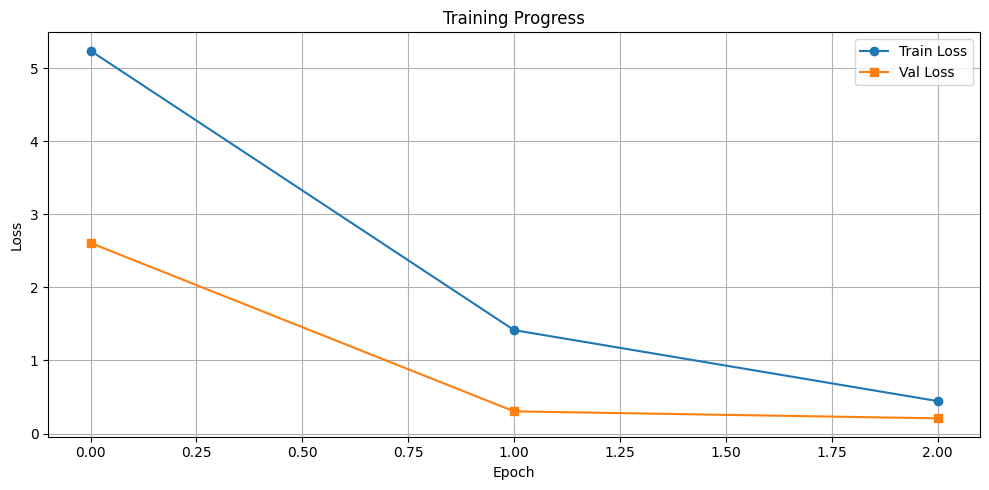

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_curve.png', dpi=150)
plt.show()

Question Asking

In [27]:
from transformers import pipeline

# Load best saved model
qa_pipeline = pipeline(
    'question-answering',
    model='./best_qa_model',
    tokenizer='./best_qa_model',
    device=0 if torch.cuda.is_available() else -1
)

def ask(question, context):
    result = qa_pipeline(question=question, context=context)
    print(f"Question: {question}")
    print(f"Answer:   {result['answer']}")
    print(f"Confidence: {result['score']:.2%}")
    return result

# Test with a passage from your data
test_context = all_passages[0]['context']
test_question = f"What is {raw_articles[0]['title']}?"

ask(test_question, test_context)

Loading weights:   0%|          | 0/102 [00:00<?, ?it/s]

Question: What is Artificial intelligence?
Answer:   .
Confidence: 0.06%


{'score': 0.0005904074641875923, 'start': 212, 'end': 213, 'answer': '.'}

Interactive QA — Ask Anything From Wikipedia Data

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Semantic search to find best context passage for a question
# !pip install sentence-transformers

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Pre-compute passage embeddings
print("Embedding all passages for retrieval...")
passage_texts = [p['context'] for p in all_passages]
passage_embeddings = embedder.encode(passage_texts, show_progress_bar=False)

def answer_question(question, top_k=3):
    # 1. Find most relevant passages via cosine similarity
    q_embedding = embedder.encode([question])
    similarities = cosine_similarity(q_embedding, passage_embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]

    # 2. Use QA model on best passage
    best_context = passage_texts[top_indices[0]]
    result = qa_pipeline(question=question, context=best_context)

    print(f"\nQuestion: {question}")
    print(f"Answer: {result['answer']}")
    print(f"Confidence: {result['score']:.2%}")
    print(f"Source passage (first 200 chars): {best_context[:200]}...")
    return result

# Try your own questions!
answer_question("What is machine learning?")
answer_question("How does a neural network work?")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding all passages for retrieval...

Question: What is machine learning?
Answer: learning by Rebellion Research to predict the 2008 financial crisis.
Confidence: 30.86%
Source passage (first 200 chars): learning by Rebellion Research to predict the 2008 financial crisis. In 2012, co-founder of Sun Microsystems, Vinod Khosla, predicted that 80% of medical doctors jobs would be lost in the next two dec...

Question: How does a neural network work?
Answer: least one hidden layer of nodes and an output.
Confidence: 7.52%
Source passage (first 200 chars): least one hidden layer of nodes and an output. Each node applies a function and once the weight crosses its specified threshold, the data is transmitted to the next layer. A network is typically calle...


{'score': 0.0751550942659378,
 'start': 0,
 'end': 46,
 'answer': 'least one hidden layer of nodes and an output.'}

In [32]:
import json

# Path to your notebook
NOTEBOOK_PATH = '/content/drive/MyDrive/Colab Notebooks/Language_Model_Creation_From_Wikipedia.ipynb'  # change this

with open(NOTEBOOK_PATH, 'r') as f:
    nb = json.load(f)

# Remove the bad widget metadata
if 'widgets' in nb.get('metadata', {}):
    del nb['metadata']['widgets']
    print("Removed widgets metadata")
else:
    print("No widgets metadata found")

# Also clean from individual cells
for cell in nb.get('cells', []):
    for output in cell.get('outputs', []):
        if 'metadata' in output:
            output['metadata'].pop('needs_background', None)
        # Remove widget outputs
        if output.get('output_type') == 'display_data':
            if 'application/vnd.jupyter.widget-view+json' in output.get('data', {}):
                output['data'] = {'text/plain': ['[Widget output removed]']}
                output['metadata'] = {}

with open(NOTEBOOK_PATH, 'w') as f:
    json.dump(nb, f, indent=1)

print("Notebook cleaned and saved!")

Removed widgets metadata
Notebook cleaned and saved!


In [31]:
!ls


best_qa_model  sample_data  training_curve.png
